Porto Seguro's Safe Driver Prediction
====

## Introduction
[This competition](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data) is hosted by the third largest insurance company in Brazil: Porto Seguro with the task of predicting the probability that a driver will initiate an insurance claim in the next year.

In the train data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. **Values of -1 indicate that the feature was missing** from the observation. The target columns signifies whether or not a claim was filed for that policy holder

train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read csv file and take a look at it
train = pd.read_csv('./train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0] # Your code here
columns = train.shape[1] # Your code here
print("The train dataset contains {} rows and {} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


## 1. Data Quality Checks

### Null or missing values check
Let check whether there are any null values in the train dataset as follows:

In [7]:
train.isnull().values.any()

False

**Note:** Our null values check returns False but however, this does not really mean that this case has been closed as the data is also described as *"Values of -1 indicate that the feature was missing from the observation"*. Therefore I take it that Porto Seguro has simply conducted a blanket replacement of all null values in the data with the value of -1. Let us now inspect if there where any missing values in the data.

Here we can see that which columns contained -1 in their values so we could easily for example make a blanket replacement of all -1 with nulls first as follows:

In [8]:
train_copy = train.copy()
train_copy = train_copy.replace(-1, np.NaN)

We can use "Missingno" to visualize missing values in the dataset.

In [14]:
!pip install missingno

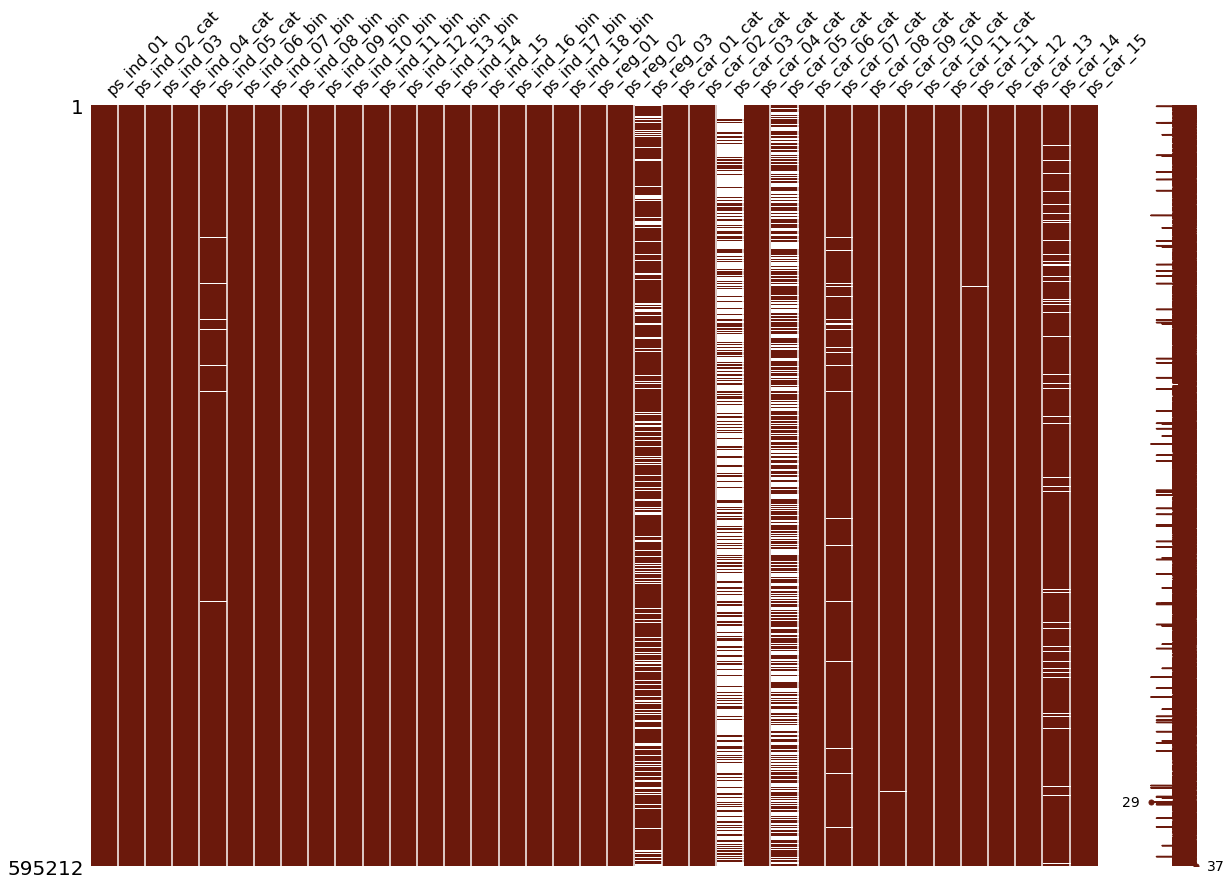

In [15]:
# If you don't have "Missingno" package, use this command to install
# (Linux) conda install -c conda-forge missingno
import missingno as msno

msno.matrix(df=train_copy.iloc[:, 2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

In [21]:
# List null columns name
# Hint: isnull()
train_copy.columns[train_copy.isnull().any()].tolist()

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_reg_03',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_05_cat',
 'ps_car_07_cat',
 'ps_car_09_cat',
 'ps_car_11',
 'ps_car_12',
 'ps_car_14']

#### Target variable inspection

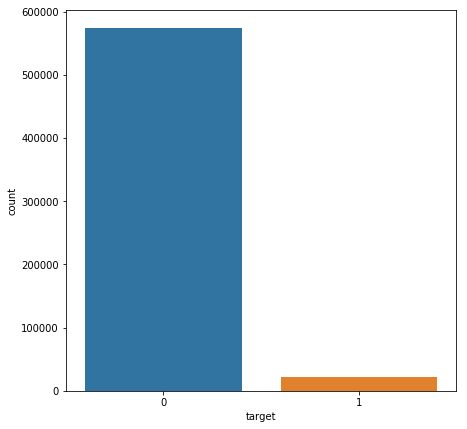

In [22]:
# Using countplot to represent target
fig = plt.figure(figsize=(7,7)) # Set figsize
sns.countplot(data=train, x='target')

plt.show()

## 2. Feature inspection and filtering

### Correlation plots
As a starter, let us generate some linear correlation plots just to have a quick look at how a feature is linearly correlated to the next and perhaps start gaining some insights from here. At this juncture, I will use the seaborn statistical visualisation package to plot a heatmap of the correlation values. Conveniently, Pandas dataframes come with the corr() method inbuilt, which calculates the Pearson correlation. Also as convenient is Seaborn's way of invoking a correlation plot. Just literally the word "heatmap"

#### Correlation of float features

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [23]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

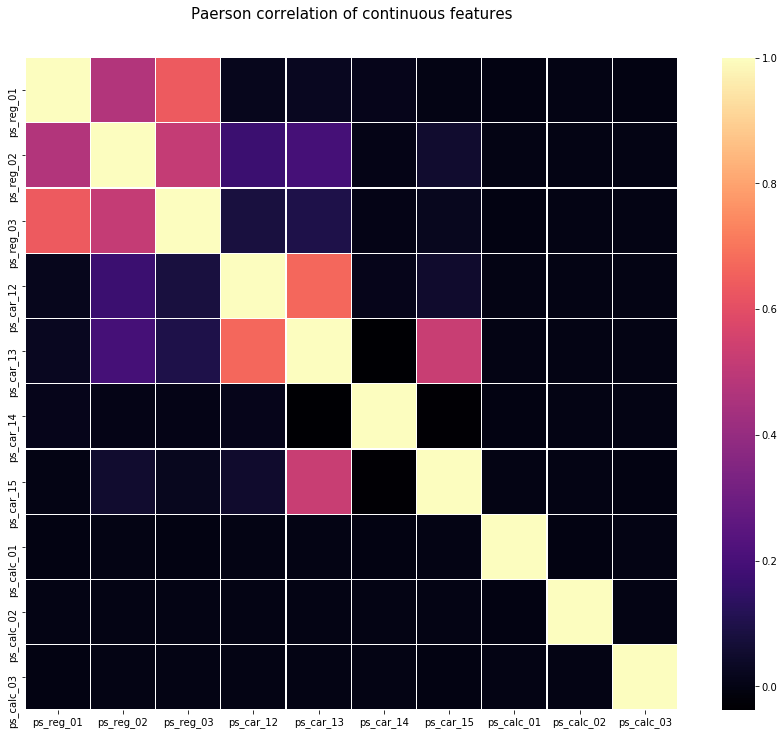

In [27]:
colormap = plt.cm.magma
plt.figure(figsize=(16, 12))
plt.title("Paerson correlation of continuous features", y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True,
           cmap=colormap)
plt.show()

From the correlation plot, we can see that the majority of the features display zero or no correlation to one another. This is quite an interesting observation that will warrant our further investigation later down. For now, the paired features that display a positive linear correlation are listed as follows:

(ps_reg_01, ps_reg_03)

(ps_reg_02, ps_reg_03)

(ps_car_12, ps_car_13)

(ps_car_13, ps_car_15)

### Correlation of integer features

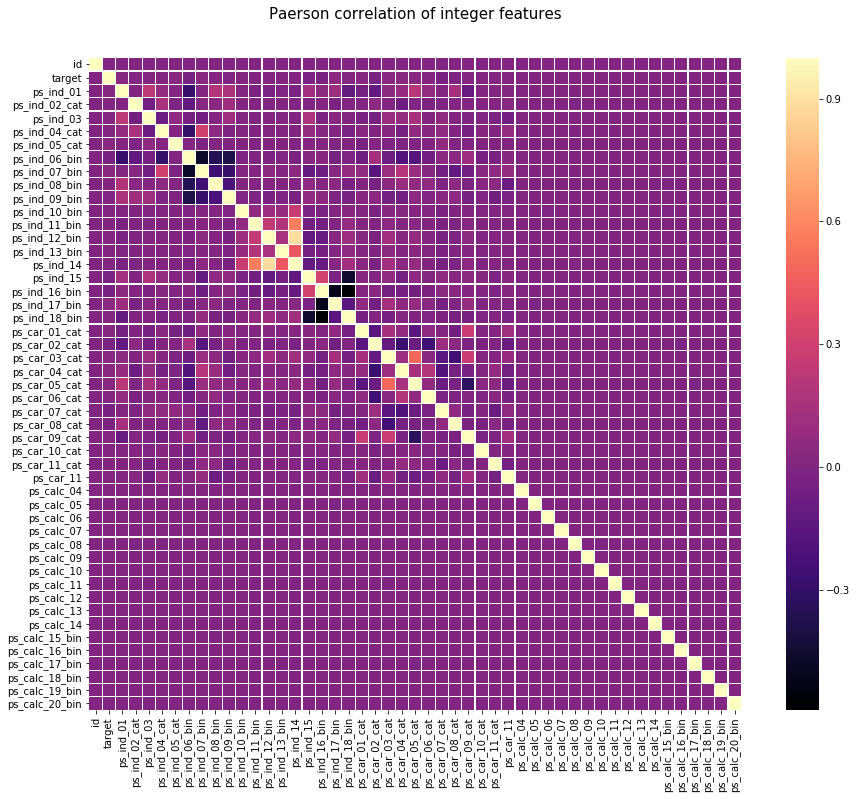

In [28]:
colormap = plt.cm.magma
plt.figure(figsize=(16, 12))
plt.title("Paerson correlation of integer features", y=1.05, size=15)
sns.heatmap(train_int.corr(), linewidths=0.1, vmax=1.0, square=True,
           cmap=colormap)
plt.show()
# Hint: correlation of train_int

#### Which features have negatively correlation?
Negatively correlated features :
(ps_ind_01, ps_ind_06_bin)
(ps_ind_04_cat, ps_ind_06_bin)
(ps_ind_06_bin, ps_ind_07_bin)
(ps_ind_06_bin, ps_ind_08_bin)
(ps_ind_06_bin, ps_ind_09_bin)
(ps_ind_07_bin, ps_ind_08_bin)
(ps_ind_07_bin, ps_ind_09_bin)
(ps_ind_15, ps_ind_18_bin)
(ps_ind_16_bin, ps_ind_17_bin)
(ps_ind_16_bin, ps_ind_18_bin)
(ps_ind_17_bin, ps_ind_18_bin)
(ps_car_02_cat, ps_car_04_cat)
(ps_car_02_cat, ps_car_06_cat)
(ps_car_03_cat, ps_car_08_cat)
(ps_car_05_cat, ps_car_09_cat)

### Binary features inspection
Another aspect of the data that we may want to inspect would be the coulmns that only contain binary valeus, i.e where values take on only either of the two values 1 or 0. Proceeding, we store all columns that contain these binary values and then generate a vertical plotly bar plot of these binary values as follows:

In [39]:
bin_col = list(filter(lambda x: '_bin' in x, train.columns))
bin_value_counts = train[bin_col].apply(pd.value_counts)

In [40]:
bin_value_counts

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,360852,442223,497644,484917,594990,594205,589594,594648,201882,523143,503879,522342,221514,265356,424278,387469,503955
1,234360,152989,97568,110295,222,1007,5618,564,393330,72069,91333,72870,373698,329856,170934,207743,91257


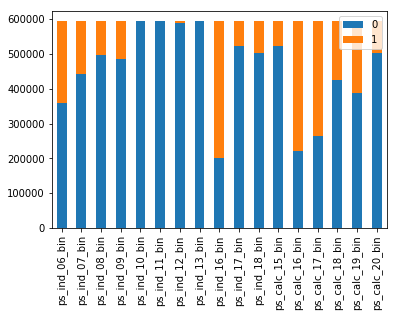

In [46]:
# hint pandas plot.bar with stacked=True
bin_value_counts.T.plot.bar(stacked=True)

Those columns ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin which are completely dominated by zeros. They do not contain much information.

## 3. Preprocess Data

In [48]:
# Import train_test_split 
from sklearn.model_selection import train_test_split

In [51]:
# Define X (features), y (target)
X = train.drop(columns = ['id','target'])
y = train['target']

In [53]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#### Randomly Under-Sampling the Training Dataset¶
**Note:** Validate ratio between 2 class after Under-Sampling

In [64]:
training_data = pd.concat([X_train,y_train], axis=1)

In [65]:
training_data.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,target
371785,0,1,8,0,0,1,0,0,0,0,...,0,3,7,1,1,1,0,0,1,0
361924,0,3,10,0,0,1,0,0,0,0,...,2,3,8,0,1,1,1,1,1,0
559522,4,2,7,1,0,0,0,0,1,0,...,2,3,3,0,1,1,1,0,0,0
526241,0,1,2,0,0,0,0,1,0,0,...,1,3,10,1,0,1,0,1,0,0
560335,2,1,3,0,0,1,0,0,0,0,...,3,1,6,0,1,0,0,0,0,0


Percentage of non-claim transactions:  0.5
Percentage of claim transactions:  0.5
Total number of transactions in resampled data:  30362


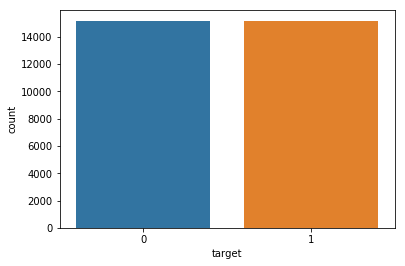

In [69]:
# Claim/non-claim data
# Select row which "target" is 1 and save in claim_data
claim_data = training_data[training_data['target'] == 1]
# Select row which "target" is 0 and save in non_claim_data
non_claim_data = training_data[training_data['target'] == 0]

# Number of clai, non-claim transactions
number_records_claim = claim_data.shape[0]
number_records_non_claim = non_claim_data.shape[0]

# Using sample function on data frame to randomly select number_records_claim from non_claim_data data frame
under_sample_non_claim = non_claim_data.sample(number_records_claim)
# **concat** under_sample_non_claim and claim_data to form under_sample_data
under_sample_data = pd.concat([under_sample_non_claim, claim_data], axis=0)

# Showing ratio
print("Percentage of non-claim transactions: ", under_sample_non_claim.shape[0] / under_sample_data.shape[0])
print("Percentage of claim transactions: ", claim_data.shape[0] / under_sample_data.shape[0])
print("Total number of transactions in resampled data: ", under_sample_data.shape[0])

sns.countplot(data=under_sample_data, x='target')
plt.show()

#### Randomly Over-Sampling the Training Dataset
**Note:** Validate ratio between 2 class after Over-Sampling

Percentage of non-claim transactions:  0.5
Percentage of claim transactions:  0.01890690891156683
Total number of transactions in resampled data:  802934


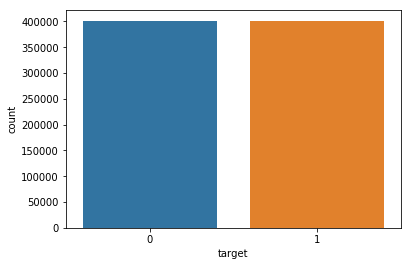

In [71]:
# Claim/non-claim data
# Select row which "target" is 1 and save in claim_data
claim_data = training_data[training_data['target'] == 1]
# Select row which "target" is 0 and save in non_claim_data
non_claim_data = training_data[training_data['target'] == 0]

# Number of claim, non-claim transactions
number_records_claim = claim_data.shape[0]
number_records_non_claim = non_claim_data.shape[0]

# Using sample function on data frame 
over_sample_claim = claim_data.sample(replace = True, n=number_records_non_claim)
# **concat** under_sample_non_claim and claim_data to form under_sample_data
over_sample_data = pd.concat([over_sample_claim, non_claim_data], axis=0)

# Showing ratio
print("Percentage of non-claim transactions: ", non_claim_data.shape[0] / over_sample_data.shape[0])
print("Percentage of claim transactions: ", claim_data.shape[0] / over_sample_data.shape[0])
print("Total number of transactions in resampled data: ", over_sample_data.shape[0])

sns.countplot(data=over_sample_data, x='target')
plt.show()

## 4. Modeling

In [72]:
# Spot check with LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
# Your code here

lr = LogisticRegression()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
bnb = BernoulliNB()
gnb = GaussianNB()

models = [lr, dtc, rfc, gnb, bnb]
models_name = ["Logistic Regression", "Decision Tree", "Random Forest", "Bernoulli NB", "Gaussian NB"]

## 5. Evaluation Metrics

In [90]:
# Import confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score

# We create an utils function, that take a trained model as argument and print out confusion matrix
# classification report base on X and y
def evaluate_model(estimator, X, y):
    prediction = estimator.predict(X)
    print('Confusion matrix:\n', confusion_matrix(y, prediction))
    print('Classification report:\n', classification_report(y, prediction))
    print('Testing set information:\n', y.value_counts)
    np.set_printoptions(precision=2)
    model_name = type(estimator).__name__
    #return {'name': model_name, 
     #       'recall': recall_score(y, prediction),
      #      'precision': precision_score(y, prediction)}

### Evaluate with Origin dataset

In [91]:
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    model.fit(X_train, y_train)
    evaluate_model(model, X_test, y_test)  
    # Evaluate model with X_test, y_test
    print("=======================================")

Model: Logistic Regression
Confusion matrix:
 [[172051      0]
 [  6513      0]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    172051
           1       0.00      0.00      0.00      6513

   micro avg       0.96      0.96      0.96    178564
   macro avg       0.48      0.50      0.49    178564
weighted avg       0.93      0.96      0.95    178564

Testing set information:
 <bound method IndexOpsMixin.value_counts of 76277     0
535243    0
64342     0
390042    0
436804    0
591821    0
16461     0
155617    0
512701    0
14953     0
460602    0
488753    0
322997    0
243377    0
366607    0
131022    0
115838    0
590276    0
467480    0
429637    0
51182     0
280734    0
22446     0
469488    0
582186    0
556199    0
86848     0
110336    0
82158     0
130991    0
         ..
230438    1
62752     0
49596     1
326202    0
13898     0
560823    0
314653    0
212674    0
139661    0
272205    0
506115

### Evaluate with *Undersampled* dataset

In [86]:
X_train_undersample = under_sample_data.drop(columns=['target'])
y_train_undersample = under_sample_data['target']
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    # Fit your model with Undersampled dataset
    model.fit(X_train_undersample, y_train_undersample)
    evaluate_model(model, X_test, y_test)
    # Evaluate model with X_test, y_test
    print("=======================================")

Model: Logistic Regression
Confusion matrix:
 [[107260  64791]
 [  2893   3620]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.62      0.76    172051
           1       0.05      0.56      0.10      6513

   micro avg       0.62      0.62      0.62    178564
   macro avg       0.51      0.59      0.43    178564
weighted avg       0.94      0.62      0.74    178564

Testing set information:
 <bound method IndexOpsMixin.value_counts of 76277     0
535243    0
64342     0
390042    0
436804    0
591821    0
16461     0
155617    0
512701    0
14953     0
460602    0
488753    0
322997    0
243377    0
366607    0
131022    0
115838    0
590276    0
467480    0
429637    0
51182     0
280734    0
22446     0
469488    0
582186    0
556199    0
86848     0
110336    0
82158     0
130991    0
         ..
230438    1
62752     0
49596     1
326202    0
13898     0
560823    0
314653    0
212674    0
139661    0
272205    0
506115

### Evaluate with *Oversampled* dataset

In [89]:
X_train_oversample = over_sample_data.drop(columns = ['target'])
y_train_oversample = over_sample_data['target']
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    model.fit(X_train_oversample, y_train_oversample)
    evaluate_model(model, X_test, y_test)    
    # Evaluate model with X_test, y_test
    print("=======================================")

Model: Logistic Regression
Confusion matrix:
 [[107925  64126]
 [  2906   3607]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.63      0.76    172051
           1       0.05      0.55      0.10      6513

   micro avg       0.62      0.62      0.62    178564
   macro avg       0.51      0.59      0.43    178564
weighted avg       0.94      0.62      0.74    178564

Testing set information:
 <bound method IndexOpsMixin.value_counts of 76277     0
535243    0
64342     0
390042    0
436804    0
591821    0
16461     0
155617    0
512701    0
14953     0
460602    0
488753    0
322997    0
243377    0
366607    0
131022    0
115838    0
590276    0
467480    0
429637    0
51182     0
280734    0
22446     0
469488    0
582186    0
556199    0
86848     0
110336    0
82158     0
130991    0
         ..
230438    1
62752     0
49596     1
326202    0
13898     0
560823    0
314653    0
212674    0
139661    0
272205    0
506115

### Conclusion

Which model has lowest/highest accuracy?
Which model has lowest/highest recall? (Highest - LR in undersampled data; Lowest - Bernoulli in undersampled data)
Which model has lowest/highest f1? (Highest - LR or Bernoulli in oversampled data; 

## 6. GridsearchCV

In [92]:
# Using gridsearchcv, random forest model and this param grid to find the best combination of parameters 
# Hint: example
# https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}



In [93]:
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier(n_jobs=4,max_features= 'sqrt' ,n_estimators=50, oob_score = True, verbose=2) 
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)

In [ ]:
CV_rfc.fit(X_train_undersample, y_train_undersample)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   28.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   29.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs

[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks   

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Don

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 108 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 con

#### which is the best combination of parameter

In [ ]:
# Your code here
CV_rfc.best_estimator_

In [ ]:
evaluate_model(CV_rfc, X_test, y_test)

# Done! Great Job.